In [0]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
train = pd.read_csv("train.csv")
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train, test_size=0.10, random_state=42)
train_df.shape #(1175509, 3)
test_df.shape       #(130613, 3)

(130613, 3)

In [0]:
#we only work with bigrams and 1-grams since it's computationally intensive

word_vectors = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word',stop_words= 'english',
                            ngram_range=(1,2),dtype=np.float32)

In [0]:
train_original = train_df
test_original = test_df

### training and test data

In [0]:
#we only work with 3% of the data for training NN since it's computationally intensive
training_data = train_original.sample(frac = 0.03)
testing_data = test_original.sample(frac = 0.03)

In [0]:
training_data.shape

(35265, 3)

In [0]:
tr_vect = word_vectors.fit_transform(training_data['question_text'])
ts_vect = word_vectors.transform(testing_data['question_text'])

In [0]:
y = training_data['target']
y_test = testing_data['target']

# Oversampling: SMOTE

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
smt = SMOTE(sampling_strategy=1)
X_smote, y_smote = smt.fit_sample(tr_vect, y)

In [0]:
X_smote.shape

(66242, 10000)

### Baseline Model: Logistic Regression

In [0]:
model = LogisticRegression()
model.fit(X_smote,y_smote)

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
#confusion matrix for test dataset 
pred =  model.predict(ts_vect)
print('\nConfusion matrix\n',confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

('\nConfusion matrix\n', array([[3139,  540],
       [  80,  159]]))
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      3679
           1       0.23      0.67      0.34       239

   micro avg       0.84      0.84      0.84      3918
   macro avg       0.60      0.76      0.62      3918
weighted avg       0.93      0.84      0.88      3918



In [0]:
x_test = ts_vect
y_score = model.decision_function(x_test)

In [0]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.41


Text(0.5,1,'Precision Recall Curve: Avg precision-recall score=0.41')

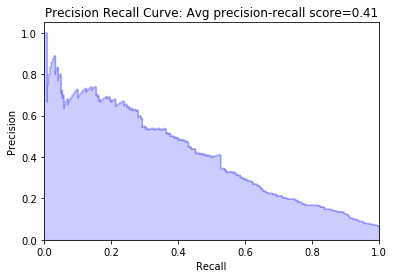

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve: Avg precision-recall score={0:0.2f}'.format(average_precision))

## NN: Multi Layer Perceptron

In [0]:
from sklearn.neural_network import MLPClassifier
X = X_smote
y = y_smote
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X, y) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
preds = clf.predict(ts_vect)
print('\nConfusion matrix\n',confusion_matrix(y_test,preds))
print 'accuracy', accuracy_score(y_test,preds)
print(classification_report(y_test,preds))

('\nConfusion matrix\n', array([[   0, 3679],
       [   0,  239]]))
accuracy 0.06100051046452271
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3679
           1       0.06      1.00      0.11       239

   micro avg       0.06      0.06      0.06      3918
   macro avg       0.03      0.50      0.06      3918
weighted avg       0.00      0.06      0.01      3918



/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
X = X_smote
y = y_smote
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10, 5, 2), random_state=1)
clf.fit(X, y) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
preds = clf.predict(ts_vect)
print('\nConfusion matrix\n',confusion_matrix(y_test,preds))
print 'accuracy', accuracy_score(y_test,preds)
print(classification_report(y_test,preds))

('\nConfusion matrix\n', array([[3151,  528],
       [  63,  176]]))
accuracy 0.8491577335375191
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      3679
           1       0.25      0.74      0.37       239

   micro avg       0.85      0.85      0.85      3918
   macro avg       0.62      0.80      0.64      3918
weighted avg       0.94      0.85      0.88      3918



In [0]:
X = X_smote
y = y_smote
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10, 5, 5, 2), random_state=1)
clf.fit(X, y) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
preds = clf.predict(ts_vect)
print('\nConfusion matrix\n',confusion_matrix(y_test,preds))
print 'accuracy', accuracy_score(y_test,preds)
print(classification_report(y_test,preds))

('\nConfusion matrix\n', array([[2991,  688],
       [  54,  185]]))
accuracy 0.810617662072486
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      3679
           1       0.21      0.77      0.33       239

   micro avg       0.81      0.81      0.81      3918
   macro avg       0.60      0.79      0.61      3918
weighted avg       0.94      0.81      0.86      3918



In [0]:
X = X_smote
y = y_smote
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10, 5, 5, 5, 2), random_state=1)
clf.fit(X, y) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 5, 5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
preds = clf.predict(ts_vect)
print('\nConfusion matrix\n',confusion_matrix(y_test,preds))
print 'accuracy', accuracy_score(y_test,preds)
print(classification_report(y_test,preds))

('\nConfusion matrix\n', array([[3243,  436],
       [  73,  166]]))
accuracy 0.8700867789688617
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3679
           1       0.28      0.69      0.39       239

   micro avg       0.87      0.87      0.87      3918
   macro avg       0.63      0.79      0.66      3918
weighted avg       0.94      0.87      0.89      3918



In [0]:
X = X_smote
y = y_smote
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10, 10, 5, 5, 5, 2), random_state=1)
clf.fit(X, y) 

preds = clf.predict(ts_vect)
print('\nConfusion matrix\n',confusion_matrix(y_test,preds))
print 'accuracy', accuracy_score(y_test,preds)
print(classification_report(y_test,preds))

('\nConfusion matrix\n', array([[3182,  497],
       [  66,  173]]))
accuracy 0.8563042368555386
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      3679
           1       0.26      0.72      0.38       239

   micro avg       0.86      0.86      0.86      3918
   macro avg       0.62      0.79      0.65      3918
weighted avg       0.94      0.86      0.89      3918

